In [70]:
import requests
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats, interpolate
from scipy.interpolate import CubicSpline
from tqdm import tqdm
from scipy.stats import uniform
from sklearn.mixture import GaussianMixture
from astropy.visualization.hist import hist as fancyhist
from sklearn.neighbors import KernelDensity
import scipy.stats
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.cluster import estimate_bandwidth
from sklearn.cluster import MeanShift

In [71]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [72]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

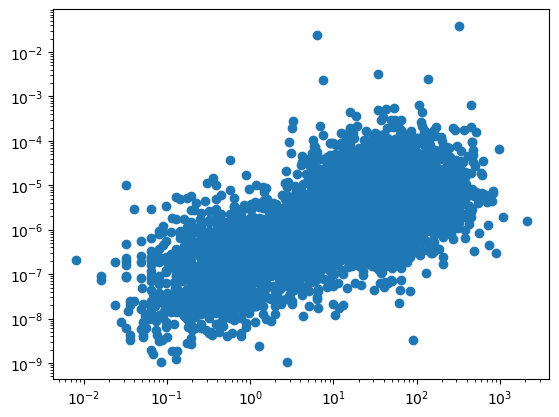

In [73]:
T90=np.array(data[6],dtype=float)
fluence=np.array(data[9],dtype=float)
plt.scatter(T90[np.logical_and(T90>0,fluence>0)], fluence[np.logical_and(T90>0,fluence>0)])
plt.loglog();

In [74]:
X = np.hstack([np.expand_dims(np.log10(T90[np.logical_and(T90>0,fluence>0)]), axis=1),np.expand_dims(np.log10(fluence[np.logical_and(T90>0,fluence>0)]), axis=1)])

## K-MEANS

[ 0.31132995  0.01029996 -0.15242734 ... -0.87942607 -0.50168945
  0.49637605]


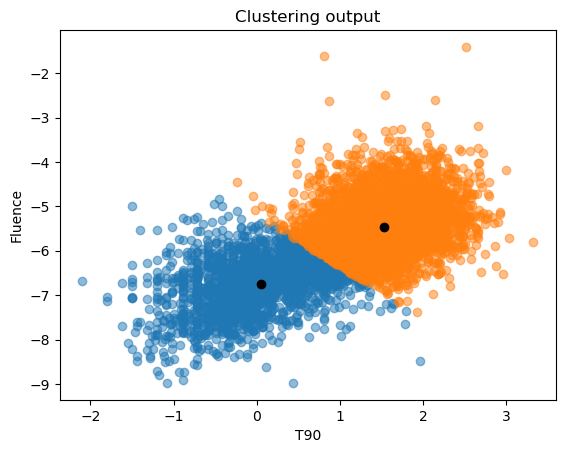

In [75]:
clf = KMeans(n_clusters=2,n_init='auto') #Try 2 clusters to start with
clf.fit(X)
centers = clf.cluster_centers_ #location of the clusters
labels = clf.predict(X) #labels for each of the points
# plot the data color-coded by cluster id
colors = ['C0', 'C1']
for ii in range(2):
    plt.scatter(X[labels==ii,0], X[labels==ii,1], 
                color=colors[ii],alpha=0.5)
print(X[labels==0,0])
# To get some information on these try:
# KMeans?
# help(clf)
plt.xlabel('T90')
plt.ylabel('Fluence')
plt.title('Clustering output')
plt.scatter(centers[:,0],centers[:,1], color='black');

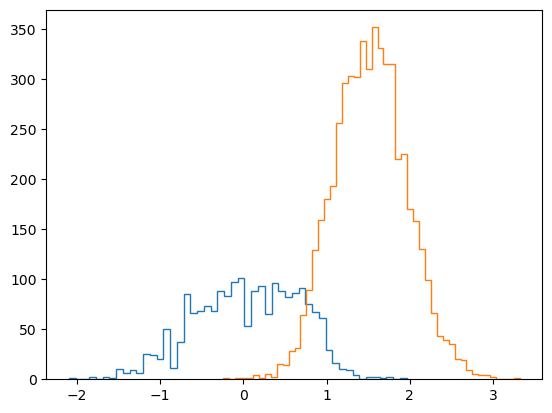

In [77]:
plt.hist(X[labels==0,0], 50, histtype='step')
plt.hist(X[labels==1,0], 50, histtype='step');

## MEAN-SHIFT

In [8]:
scaler = preprocessing.StandardScaler()
Y = scaler.fit_transform(X)
clf2 = KMeans(n_clusters=2,n_init='auto') #Try 2 clusters to start with
clf2.fit(Y)
centers2 = clf2.cluster_centers_ #location of the clusters

In [13]:
bandwidth = 0.4
#bandwidth = estimate_bandwidth(Y) # this takes a long time...beware
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False, seeds = centers2)

ms.fit(Y)

MeanShift(bandwidth=0.4, bin_seeding=True, cluster_all=False,
          seeds=array([[-1.2827707 , -1.12362972],
       [ 0.49309029,  0.43191733]]))

[-1  0  1]
0.4
number of estimated clusters : 2


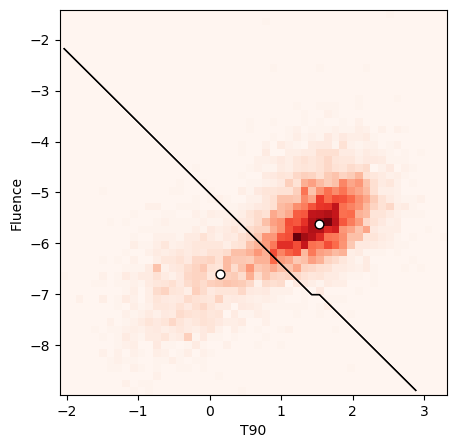

In [64]:
labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters)

# Make some plots
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X[:,0], X[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto', extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],cmap='Reds')

# plot cluster centers
cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])
Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T
#plt.scatter(Xgrid[:,0], Xgrid[:,1], color='black',s=0.1)
H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))
for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0
    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5], linewidths=1, colors='k')
 
    H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

ax.set_xlabel('T90')
ax.set_ylabel('Fluence')

plt.show()